In [6]:
def get_timelocked_activity(times, hg, back, forward, hz=False):
    '''
    Get time-locked activity.

    Parameters:
    - times (array-like): List of timepoints in seconds.
    - hg (numpy.ndarray): High gamma array, shaped (elecs_num, whole_duration*hz).
    - back (float): Start time before the timepoints.
    - forward (float): End time after the timepoints.
    - hz (float, optional): Sampling rate of High gamma. Default is False.

    Returns:
    - Y_mat (numpy.ndarray): Time-locked activity array, shaped (trial_num, elecs_num, selected_duration*hz).
    - back (int): Start time in samples (back*hz).
    - forward (int): End time in samples (forward*hz).
    '''
    if hz:
        times = (times*hz).astype(int)
        back = int(back*hz)
        forward = int(forward*hz)
    times = times[times - back > 0]
    times = times[times + forward < hg.shape[1]]

    Y_mat = np.zeros((len(times),hg.shape[0], int(back + forward)), dtype=float)

    for i, index in enumerate(times):
        Y_mat[i, :, :] = hg[:, int(index-back):int(index+forward)]

    return Y_mat,back,forward

def read_ecog_mat(back,forward,mat,channelNum,key_elecs=[],key_label=[],oppolabel=False,key_sentence=[],opposentence=False, key_paragraph=[],oppoparagraph=False,
                  hz=False, block=4):
    '''
    get ecog_mat based on defined parameters
    
    Parameters:
    - mat : shaped(7,num_of_timepoints)
    - hg (numpy.ndarray): High gamma array, shaped (elecs_num, whole_duration*hz).
    - back (float): Start time before the timepoints.
    - forward (float): End time after the timepoints.
    - hz (float, optional): Sampling rate of High gamma. Default is False.
    channelNum:number of electrodes 128 or 256
    block:number of blocks included, usually from 1 to 4
    key_elecs: selected elecs
    kay_labels:selected labels, opplabel means oppose the key_label
    sentence and paragraphs similarly
    '''

    key_elecs = np.array(key_elecs)
    key_index = np.ones(len(mat[0,:])).astype('bool')
    
    sentence_index = np.ones(len(mat[0,:])).astype('bool')
    label_index = np.ones(len(mat[0,:])).astype('bool')
    paragraph_index = np.ones(len(mat[0,:])).astype('bool')  
    
    if key_label:
        print('select label:'+str(key_label),end=' ')
        label_index=~label_index
        for i in key_label:
            temp_index = mat[0,:] ==i
            label_index = np.logical_or(label_index, temp_index)
        if oppolabel:
            print('oppo')
            label_index=~label_index
    key_index = np.logical_and(label_index, key_index)
    if key_sentence:
        print('select sentence:'+str(key_sentence),end=' ')
        sentence_index=~sentence_index
        for i in key_sentence:
            temp_index = mat[2,:] ==i
            sentence_index = np.logical_or(sentence_index, temp_index)
        if opposentence:
            print('oppo')
            sentence_index=~sentence_index
    key_index = np.logical_and(sentence_index, key_index)        
    if key_paragraph:
        print('select paraqraph:'+str(key_paragraph),end=' ')
        paragraph_index=~paragraph_index
        for i in key_paragraph:
            temp_index = mat[3,:] ==i
            paragraph_index = np.logical_or(paragraph_index, temp_index)
        if oppoparagraph:
            print('oppo')
            paragraph_index=~paragraph_index
    key_index = np.logical_and(paragraph_index, key_index)      
    mat = mat[:,key_index]
       
    
    if key_elecs.any():
        ecog_mat = np.zeros((len(mat[0,:]),len(key_elecs), int((back+forward)*hz)), dtype=float)
        print('select elecs:'+str(key_elecs),end=' ')
    else:
        ecog_mat = np.zeros((len(mat[0,:]),channelNum, int((back+forward)*hz)), dtype=float)
        
    for i in range(block):
        block_index= mat[4,:]==i+1
        temp_time_list=mat[1,block_index]
        ecogData=scio.loadmat(path_raw+str(i+1)+filterType+'.mat')#################################
        ecogData=np.array(ecogData['bands'])*10e4
        #print('###',np.nanmean(np.max(ecogData,axis=1)-np.min(ecogData,axis=1)),np.array(np.max(ecogData,axis=1)).shape)######################################################################################
        temp_ecog,back_duration,forward_duration = get_timelocked_activity(times=temp_time_list, hg=ecogData, back=back, forward=forward, hz=hz)
        if key_elecs.any():
            key_elecs = np.array(key_elecs)
            ecog_mat[block_index] = temp_ecog[:,key_elecs,:]
        else:
            ecog_mat[block_index] = temp_ecog

    print('read_ecog:',ecog_mat.shape)
    return ecog_mat,back_duration,forward_duration,mat

'''
EXAMPLE:
ecog_mat,back_duration,forward_duration,mat = read_ecog_mat(back,forward,mat,channelNum,key_elecs=[],
                key_label=[],oppolabel=False,key_sentence=[],opposentence=False, key_paragraph=[],oppoparagraph=False,
                hz=False, block=4)
'''

def read_one_ecog(back,forward,time_list,block_list,channelNum, key_sentence, key_paragraph,
                  sentence_list,paragraph_list,key_elecs=[], hz=False,block=4):
    time_list =np.array(time_list)
    block_list = np.array(block_list)

    sentence_list = np.array(sentence_list)
    sentence_index=sentence_list==key_sentence
    paragraph_list = np.array(paragraph_list)
    paragraph_index=paragraph_list==key_paragraph
    key_index = np.logical_and(sentence_index, paragraph_index)
        

    time_list = time_list[key_index]
    block_list = block_list[key_index]
    block_chosen = block_list[0]
    ecogData=scio.loadmat(path_raw+str(block_chosen)+filterType+'.mat')
    ecogData=np.array(ecogData['bands'])*10e4  #amplitude the HG by 10e4
    temp_ecog,_,_ = get_timelocked_activity(times=time_list, hg=ecogData, 
                                                                        back=back, forward=forward, hz=hz)      
    if key_elecs:
        key_elecs = np.array(key_elecs)
        ecog_mat = temp_ecog[:,key_elecs,:]
    else:
        ecog_mat = temp_ecog

    #print(ecog_mat.shape)
    return ecog_mat
def nansem(a, axis=1):
    return np.nanstd(a, axis=axis)/np.sqrt(a.shape[axis])
def plot_filled_sem(a, xvals, ax=None, color=None, ylim=None):
    if ax is None:
        fig, ax = plt.subplots()
    mean = np.nanmean(a, axis=0)
    sem = nansem(a, axis=0)
    
    ax.axvline(0, color='gray', linewidth=0.5)
    ax.axhline(0, color='gray', linewidth=0.5)

    if color is not None:
        h = ax.fill_between(xvals, mean-sem, mean+sem, alpha=0.6, color=color)
    else:
        h = ax.fill_between(xvals, mean-sem, mean+sem, alpha=0.6,)
        
    if ylim is not None:
        ax.set(ylim=ylim)
    ax.set(xlim=(xvals[0], xvals[-1]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

def plot_legend(List, color_list,save = False):
    if color_list is False:
        color_list = plt.cm.tab10.colors[:len(List)]
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(0.4, 1))

    # Turn off axis for a cleaner plot without actual data
    ax.axis('off')

    # Plot each color as a square with the corresponding name for the legend
    for i, (color, label) in enumerate(zip(color_list, List)):
        ax.scatter([], [], c=[color], label=label, marker='s', s=100)  # Adjust 's' for marker size
    # Create the legend with the specified names and colors, adjust the legend position
    ax.legend(loc='center', bbox_to_anchor=(0.5, 0.5), frameon=False)
    # Save the figure as SVG with a transparent background
    if save:
        fig.savefig(str(List)+'legend.svg', transparent=True)
    # Show the plot (optional)
    plt.show()
    return(color_list)
'''
EXAMPLE
plot_legend(sylbList, color_list = False)
'''
def ERP_figure(matlist,color_list=['r','g','b']):
    fig, axs = plt.subplots(int(channelNum/8), 8, figsize=(25, int(channelNum*25/128)))
    xvals = np.linspace(-1.5, 1.5, matlist[0].shape[2])
    pidx = channelNum-1
    for i in range(int(channelNum/8)):
        for j in range(8):
            color_index = 0
            for ecog_mat in matlist:
                a = ecog_mat[:,pidx,:]
                for k in range(a.shape[0]):
                    a[k,:]-=np.nanmean(a[k,:])
                    a[k,:]/=np.nanstd(a[k,:])
                plot_filled_sem(a, xvals, ax= axs[i,j] ,ylim=(-1, 3), color=color_list[color_index])
                color_index+=1

            ax=axs[i,j].twinx()
            ax.set_yticks([])
            ax.set_ylim(-1,3)
            ax.text(0.55, 0.85, str(pidx+1), transform=ax.transAxes)
            pidx -=1
    plt.savefig('ERPAll.png')
    
def single_elecs_ERP(matlist,pidx, window, sig_flag = False,color_list=['y','g','b']):
    fig, ax = plt.subplots(figsize=(2, 1.5))
    xvals = np.linspace(window[0], window[-1], matlist[0].shape[2]) 
    ax.set(xlabel="Time (s)", ylabel="High-gamma \n(z-score)")
    color_index = 0
    for ecog_mat in matlist:
        a = ecog_mat[:,pidx,:]
        for k in range(a.shape[0]):
            a[k,:]-=np.nanmean(a[k,:])
            a[k,:]/=np.nanstd(a[k,:])
        plot_filled_sem(a, xvals, ax= ax ,ylim=(-0.6, 1.2), color=color_list[color_index])
        color_index+=1
    ax=ax.twinx()
    ax.set_yticks([])
    ax.set_ylim(-0.6,1.2)################-1to1############
    ax.set(yticklabels=[], xticklabels=window, xticks=window)
    #ax.grid(True) 
    if sig_flag is not False:
        y_coordinate = -0.3
        indices_of_true = np.where(sig_flag)[0]
        #print(indices_of_true)
        ax = sns.scatterplot(x=xvals[indices_of_true], y=[y_coordinate]*len(indices_of_true),s = 10,
                        color='black', lw=0.1)
    #ax.text(0.55, 0.85, 'HS31 channel '+str(pidx+1), transform=ax.transAxes)
    plt.title(str(pidx+1))
    if save is not False:
        if pidx in save:
            #print('save:', pidx)
            plt.savefig(str(pidx+1)+"_onset.svg", format="svg", dpi=300)
    plt.show()

def pick_resp_electrodes(baso_ecog_mat,resp_ecog_mat,thres_length,channelNum,P0):
    #use baso_ecog_mat and resp_ecog_mat to generate list of responsive elecs
    sig_elecs = []
    thres_len = int(thres_length*hz) #significance for continous thres_len*10ms
    thres = P0/thres_len/channelNum  #bonferroni correction
    matlist = [resp_ecog_mat,]
    for pidx in tqdm(range(int(channelNum))):
        b = baso_ecog_mat[:,pidx].reshape(1,-1)  #get baseline
        c = resp_ecog_mat.shape[2]
        sig_flag = np.zeros(c)
        for t in range(c):
            d = resp_ecog_mat[:,pidx,t].reshape(1,-1) #t-test for every timepoint
            p_val = stats.ttest_ind(b[:, ~np.isnan(b).any(axis=0)].T,
                                    d[:, ~np.isnan(d).any(axis=0)].T).pvalue
            if p_val < thres:
                sig_flag[t] = 1
        is_sig = False
        for k in range(c-thres_len+1): 
            if np.sum(sig_flag[k:k+thres_len]) > thres_len-1:
                is_sig = True
        if is_sig == True:
            sig_elecs.append(pidx)
            if plot:
                single_elecs_ERP(matlist,pidx,[-sylb_back,0,sylb_forward],sig_flag,color_list=['y','g','b'])
            
    print('resp_elecs:',sig_elecs)
        
    return sig_elecs

'''
        resp_elecs = pick_resp_electrodes(baso_ecog_mat=baso_ecog_mat,resp_ecog_mat=sylb_temp_ecog_mat,
                             thres_length = overt_thres_length,channelNum=channelNum,P0=P0)
'''
def pick_disc_electrodes2(List, mat, ecog_mat, thres_length,channelNum,P0=0.05,row=0):
    color_list = plot_legend(List, color_list = False)
    disc_elecs = []
    thres_len = int(thres_length*hz) #half of the timepoints within this duration is significance
    threshold = P0/thres_len*2/channelNum # #correction
    sig_elecs = []
    matlist = []
    for ch in range(len(List)):
        matlist.append(ecog_mat[mat[row,:] == ch,:,:])

    for pidx in tqdm(range(int(channelNum))):
        matlist[0][:,pidx,:]
        c = matlist[0].shape[2]
        sig_flag = np.zeros(c)
        for t in range(c):
            b0 = matlist[0][:,pidx,t].reshape(1,-1)
            b1 = matlist[1][:,pidx,t].reshape(1,-1)
            b2 = matlist[2][:,pidx,t].reshape(1,-1)
            b3 = matlist[3][:,pidx,t].reshape(1,-1)
            b4 = matlist[4][:,pidx,t].reshape(1,-1)
            b5 = matlist[5][:,pidx,t].reshape(1,-1)
            b6 = matlist[6][:,pidx,t].reshape(1,-1)
            b7 = matlist[7][:,pidx,t].reshape(1,-1)
            b8 = matlist[8][:,pidx,t].reshape(1,-1)
            b9 = matlist[9][:,pidx,t].reshape(1,-1)
            
            p_val = stats.f_oneway(b0[:, ~np.isnan(b0).any(axis=0)].T,
                                    b1[:, ~np.isnan(b1).any(axis=0)].T,
                                    b2[:, ~np.isnan(b2).any(axis=0)].T,
                                    b3[:, ~np.isnan(b3).any(axis=0)].T,
                                    b4[:, ~np.isnan(b4).any(axis=0)].T,
                                    b5[:, ~np.isnan(b5).any(axis=0)].T,
                                    b6[:, ~np.isnan(b6).any(axis=0)].T,
                                    b7[:, ~np.isnan(b7).any(axis=0)].T,
                                    b8[:, ~np.isnan(b8).any(axis=0)].T,
                                    b9[:, ~np.isnan(b9).any(axis=0)].T).pvalue #anova test

            if p_val < threshold:
                sig_flag[t] = 1
        is_sig = False
        for k in range(c-thres_len+1):
            if np.sum(sig_flag[k:k+thres_len]) > thres_len/2:
                is_sig = True
        if is_sig == True:
            sig_elecs.append(pidx)
            if plot:
                single_elecs_ERP(matlist,pidx,[-sylb_back,0,sylb_forward],sig_flag,color_list=color_list)
                
    disc_elecs=sig_elecs

    print('disc_elecs:',set(disc_elecs))
    disc_elecs = np.array(disc_elecs) 
    return disc_elecs

'''
print(sylb_temp_ecog_mat.shape)
sylb_elecs = pick_disc_electrodes(List=stlbList,mat=sylb_trainval, ecog_mat=sylb_temp_ecog_mat,thres_length=sylb_thres_length,
                                  channelNum=channelNum,P0=P0)
'''
def pick_disc_electrodes3(List, mat, ecog_mat, thres_length,channelNum,P0=0.05,row=0):
    color_list = plot_legend(List, color_list = False)
    disc_elecs = []
    thres_len = int(thres_length*hz) 
    threshold = P0/thres_len*2/channelNum
    sig_elecs = []
    matlist = []
    for ch in range(len(List)):
        matlist.append(ecog_mat[mat[row,:] == ch,:,:])
    
    for pidx in tqdm(range(int(channelNum))):
        matlist[0][:,pidx,:]
        c = matlist[0].shape[2]
        sig_flag = np.zeros(c)
        for t in range(c):
            b0 = matlist[0][:,pidx,t].reshape(1,-1)
            b1 = matlist[1][:,pidx,t].reshape(1,-1)
            b2 = matlist[2][:,pidx,t].reshape(1,-1)
            b3 = matlist[3][:,pidx,t].reshape(1,-1)
            
            p_val = stats.f_oneway(b0[:, ~np.isnan(b0).any(axis=0)].T,
                                    b1[:, ~np.isnan(b1).any(axis=0)].T,
                                    b2[:, ~np.isnan(b2).any(axis=0)].T,
                                    b3[:, ~np.isnan(b3).any(axis=0)].T).pvalue #anova

            if p_val < threshold:
                sig_flag[t] = 1
        is_sig = False
        for k in range(c-thres_len+1): 
            if np.sum(sig_flag[k:k+thres_len]) > thres_len/2:
                is_sig = True
        if is_sig == True:
            sig_elecs.append(pidx)
            if plot:
                single_elecs_ERP(matlist,pidx,[-tone_back,0,tone_forward],sig_flag,color_list=color_list)
            
    disc_elecs=sig_elecs

    print('disc_elecs:',set(disc_elecs))
    disc_elecs = np.array(disc_elecs) 
    return disc_elecs

'''
print(sylb_temp_ecog_mat.shape)
sylb_elecs = pick_disc_electrodes(List=sylbList,mat=sylb_trainval, ecog_mat=sylb_temp_ecog_mat,thres_length=sylb_thres_length,
                                  channelNum=channelNum,P0=P0)
'''

'\nprint(sylb_temp_ecog_mat.shape)\nsylb_elecs = pick_disc_electrodes(List=sylbList,mat=sylb_trainval, ecog_mat=sylb_temp_ecog_mat,thres_length=sylb_thres_length,\n                                  channelNum=channelNum,P0=P0)\n'

In [2]:
#import transformers
#from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

import h5py
import json

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os

import pandas as pd

from random import shuffle,randint

from scipy.fftpack import fft
import scipy.stats as stats
import scipy.io as scio
from scipy.io import wavfile
from scipy import signal
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


from tqdm import tqdm
from torchmetrics.functional import word_error_rate as wer
from textwrap import wrap
import textgrid as tg
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch
from torch import nn, optim, einsum
import torch.utils.data as Data
from torch.utils.data import DataLoader,TensorDataset
import wave


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
date='1119'
print(date)
subject = 'PA4'

1119


In [3]:
path_raw='./Raw/B'
sylbList = ['shi', 'de', 'ji', 'li', 'bu', 'ge', 'qi', 'zhe', 'ta', 'zhi']
stateList=['silent','speech']
toneList = ['1','2','3','4']
charList =  ['失', '十', '时', '实', '是', '的', '地', '得', '机', '激',
            '极', '记', '计', '迹', '离', '里', '理', '励', '荔', '不',
            '布', '哥', '搁', '个', '七', '奇', '其', '起', '契', '折',
            '者', '这', '他', '塔', '织', '枝', '职', '止', '置', '智']
hz = 400 #sampling rate of the highgamma band
filterType = '_70_150' #
interval = 0.01 #generate a speech/rest state label for every 0.01 second
earlystart = 2  #clip 2s before sentence onset 

In [7]:
'''
generate overt_mat,sylb_mat and baso_mat
overt_mat contains the speech/rest state of each timepoint
sylb_mat contain the onset timepoints of each syllable
baso_mat contain the onset of each sentences, which are used for collecting baseline data
detailed contents of the generated mat see follows
'''
overt_mat = False
sylb_mat = False
baso_mat = False

for blockNum in [1,2,3,4]:
    TG = tg.TextGrid.fromFile(path_raw+str(blockNum)+'sound_mat.TextGrid')
    print(TG)
    
    windowTimeList = np.array(np.arange(TG[2][0].maxTime-earlystart,
                                        TG[2][len(TG[2].intervals)-1].minTime-earlystart,
                                        interval))
    
    temp_mat = np.zeros((5,len(windowTimeList)))
    temp_mat[4,:] = np.ones(len(windowTimeList))* blockNum#overt_mat[4,:] = np.array(blockList)
    temp_mat[1,:] = windowTimeList

    for i in range(len(TG[0].intervals)):
        if str(TG[0][i].mark)in['sil',]:
            pass
        elif str(TG[0][i].mark)in['?','','？']:
            index1= windowTimeList>=TG[0][i].minTime
            index2= windowTimeList<TG[0][i].maxTime
            index=np.logical_and(index1,index2)
            temp_mat[0][index]= np.nan
        else: 
            #print(str(TG[0][i].mark),end='#')
            index1= windowTimeList>=TG[0][i].minTime
            index2= windowTimeList<TG[0][i].maxTime
            index=np.logical_and(index1,index2)
            temp_mat[0][index]= 1
            
    for i in range(len(TG[1].intervals)):
        if TG[1][i].mark:
            index1= windowTimeList>=TG[1][i].minTime-earlystart
            index2= windowTimeList<TG[1][i].maxTime-earlystart
            index=np.logical_and(index1,index2)
            temp_mat[2][index] = TG[1][i].mark
            #if blockNum==2:#######################################################################
                #print(TG[1][i].mark,np.nanmean(index))
    for i in range(len(TG[2].intervals)):
        if TG[2][i].mark:
            index1= windowTimeList>=TG[2][i].minTime-earlystart
            index2= windowTimeList<TG[2][i].maxTime-earlystart
            index=np.logical_and(index1,index2)
            temp_mat[3][index] = TG[2][i].mark

    valid_columns = np.all(~np.isnan(temp_mat), axis=0)
    temp_mat = temp_mat[:, valid_columns]
    
    if overt_mat is not False:
        overt_mat = np.hstack((overt_mat, temp_mat))
    else:
        overt_mat = temp_mat
    
    ################################################################################33
    temp_mat = np.zeros((7,len(TG[0].intervals)))
    temp_mat[4,:] = np.ones(len(TG[0].intervals))* blockNum#overt_mat[4,:] = np.array(blockList)
    
    for i in range(len(TG[0].intervals)):#
        if str(TG[0][i].mark)=='':
            temp_mat[0][i]=np.nan
        elif str(TG[0][i].mark)[-1] not in charList:
            if str(TG[0][i].mark)[-1] not in ['l','?','？']:
                print('error label')
            temp_mat[0][i]=np.nan
        else:
            #print(str(TG[0][i].mark),end='')
            print(str(TG[0][i].mark),end='')
            print(str(TG[0][i].minTime),end='')
            temp_mat[0][i] = sylbList.index(str(TG[0][i].mark)[:-2])
            temp_mat[5][i] = toneList.index(str(TG[0][i].mark)[-2:-1])
            if str(TG[0][i].mark)[-1:] == '她':#some of the annotations make the mistake
                temp_mat[6][i] = charList.index('他')
            else:
                temp_mat[6][i] = charList.index(str(TG[0][i].mark)[-1:])
            temp_mat[1][i] = TG[0][i].minTime
                        
    for i in range(len(TG[1].intervals)):
        if TG[1][i].mark:
            index1= temp_mat[1]>=TG[1][i].minTime
            index2= temp_mat[1]<TG[1][i].maxTime
            index=np.logical_and(index1,index2)
            temp_mat[2][index] = TG[1][i].mark
            
    for i in range(len(TG[2].intervals)):
        if TG[2][i].mark:
            index1=temp_mat[1]>=TG[2][i].minTime
            index2=temp_mat[1]<TG[2][i].maxTime
            index=np.logical_and(index1,index2)
            temp_mat[3][index] = TG[2][i].mark
                        
    valid_columns = np.all(~np.isnan(temp_mat), axis=0)
    temp_mat = temp_mat[:, valid_columns]              
    if sylb_mat is not False:
        sylb_mat = np.hstack((sylb_mat, temp_mat))
    else:
        sylb_mat = temp_mat

    #################################################################################
    temp_mat = np.zeros((5,len(TG[1].intervals)))
    temp_mat[0,:] = np.ones(len(TG[1].intervals)) #baso_mat[0,:] = np.ones(len(TG[0].intervals))
    temp_mat[4,:] = np.ones(len(TG[1].intervals))* blockNum #baso_mat[4,:] = np.array(basoBlockList)
                        
    for i in range(len(TG[1].intervals)):
        if str(TG[1][i].mark)=='':
            temp_mat[0][i]=np.nan
        if str(TG[1][i].mark) not in ['1','2','3','4','5','6','7','8','9','10']:
            temp_mat[0][i]=np.nan
        else:
            temp_mat[1][i]=TG[1][i].minTime
            temp_mat[2][i]=TG[1][i].mark
                        
    for i in range(len(TG[2].intervals)):
        if TG[2][i].mark:
            index1=temp_mat[1]>=TG[2][i].minTime
            index2=temp_mat[1]<TG[2][i].maxTime
            index=np.logical_and(index1,index2)
            temp_mat[3][index] = TG[2][i].mark
            
    valid_columns = np.all(~np.isnan(temp_mat), axis=0)
    temp_mat = temp_mat[:, valid_columns]              
    if baso_mat is not False:
        baso_mat = np.hstack((baso_mat, temp_mat))
    else:
        baso_mat = temp_mat

<TextGrid None, 3 Tiers>
ta1他24.2053ge1哥25.07445bu4不26.36158li3理27.52608ta1他28.61417ta1他33.95785de4的34.73662li4荔35.69865zhi1枝36.42733qi1七37.7808zhe2折39.46785qi3起40.52276zhe4这46.39973li3里47.27476de1的48.42044ta3塔49.33514shi4是50.47258ge4个51.71717qi2奇52.79691ji4迹54.15458ta1他59.7114ji2极60.75818qi2其61.94507ji1机62.9836zhi4智64.25292zhi3止69.56057zhi4智70.13313zhe3者70.73897bu4不72.03301de1得73.04682bu4不74.28316li2离75.55643zhi2职76.65265ta1他81.78302qi2其82.78034shi2实83.83535bu4不85.11266zhi3止86.06877qi1七87.31336shi2十88.46728zhi4智94.31473zhe3者95.2581bu2不96.46148ji4计97.56595de2得98.85175shi1失99.77489zhi1织105.38745bu4布106.39301ji1机107.51397shi4是108.73363zhe4这110.0524li3里111.40384de1的112.54952ge1哥117.7746ge1哥118.73071bu4不119.90111shi2时121.01383de4地122.39029ji1激123.45355li4励124.81343ta1他126.16487ge1搁131.43546zhi2置132.39981zhe4这133.71033ge4个135.07032qi4契136.31875ji1机137.46443ta1他142.73477de4的143.67439li4荔144.90249zhi1枝146.22951qi1七147.46585zhe2折148.83792qi3起149.97536zhi4智155.05228zhe3者156.18147bu2不157.31067ji

In [8]:
print(overt_mat.shape)
print(overt_mat[0,:]) #label: speech is 1 and rest is 0
print(overt_mat[1,:]) #timepoints: start from each block, unit is second
print(overt_mat[2,:]) #this timepoint belongs to which type of sentence (from 1 to 10)
print(overt_mat[3,:]) #this timepoint belongs to which trial (from 1 to 16)
print(overt_mat[4,:]) #this timepoint belongs to which block (from 1 to 4)

print(sylb_mat.shape)
print(sylb_mat[1,:]) #label: ['shi', 'de', 'ji', 'li', 'bu', 'ge', 'qi', 'zhe', 'ta', 'zhi'] from 1 to 10
print(sylb_mat[0,:]) #time of syllable onset: start from each block, unit is second
print(sylb_mat[2,:]) #this syllable belongs to which type of sentence (from 1 to 10)
print(sylb_mat[3,:]) #this syllable belongs to which trial (from 1 to 16)
print(sylb_mat[4,:]) #this syllable belongs to which block (from 1 to 4)
print(sylb_mat[5,:]) #the lexical tone of this syllable (from 1 to 4)
print(sylb_mat[6,:]) #the Chinese character of this syllable (from 1 to 40)
                     #['失', '十', '时', '实', '是', '的', '地', '得', '机', '激',
                     #'极', '记', '计', '迹', '离', '里', '理', '励', '荔', '不',
                     #'布', '哥', '搁', '个', '七', '奇', '其', '起', '契', '折',
                     #'者', '这', '他', '塔', '织', '枝', '职', '止', '置', '智']
                
print(baso_mat.shape)
print(baso_mat[0,:]) #label: all set as 1
print(baso_mat[1,:]) #time of sentence onset: start from each block, unit is second
print(baso_mat[2,:]) #the type of the sentence (from 1 to 10)
print(baso_mat[3,:]) #this sentence belongs to which trial (from 1 to 16)
print(baso_mat[4,:]) #this sentence belongs to which block (from 1 to 4)


(5, 178692)
[0. 0. 0. ... 1. 1. 1.]
[ 22.2053   22.2153   22.2253  ... 506.77427 506.78427 506.79427]
[1. 1. 1. ... 7. 7. 7.]
[ 1.  1.  1. ... 16. 16. 16.]
[1. 1. 1. ... 4. 4. 4.]
(7, 1034)
[ 24.2053   25.07445  26.36158 ... 505.41717 506.76727 507.79637]
[8. 5. 4. ... 2. 1. 0.]
[1. 1. 1. ... 7. 7. 7.]
[ 1.  1.  1. ... 16. 16. 16.]
[1. 1. 1. ... 4. 4. 4.]
[0. 0. 3. ... 3. 1. 0.]
[32. 21. 19. ... 12.  7.  0.]
(5, 158)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 24.2053   33.95785  46.39973  59.7114   69.56057  81.78302  94.31473
 105.38745 117.7746  131.4

In [9]:
np.save(subject+'_overt_mat',overt_mat)
np.save(subject+'_sylb_mat',sylb_mat)
#np.save(subject+'_baso_mat',baso_mat)

In [10]:
#get speech responsive elecs
channelNum = 256
sylb_back = 0.4
sylb_forward = 0.8
basoBack = 1.8
overt_thres_length = 0.1
P0= 0.01

#use sylb_mat to generate ecog_mat of speech state
sylb_ecog_mat,_,_,_ = read_ecog_mat(sylb_back,sylb_forward,sylb_mat,channelNum,key_elecs=[],
        key_label=[],oppolabel=False,key_sentence=[],opposentence=False, key_paragraph=[13,14,15,16],oppoparagraph=True,
        hz=hz, block=4) 

#use baso_mat to generate baso_ecog_mat of rest state
baso_ecog_mat,_,_,_ = read_ecog_mat(basoBack,-sylb_back,baso_mat,channelNum,key_elecs=[],
        key_label=[],oppolabel=False,key_sentence=[],opposentence=False, key_paragraph=[13,14,15,16],oppoparagraph=True,
        hz=hz, block=4)

plot = False #set true can see the ERP on each sig elec
save = False #set [254,] can save the typical ERP, do not forget to minus 1, must set plot as Ture first
resp_elecs = pick_resp_electrodes(baso_ecog_mat=baso_ecog_mat,resp_ecog_mat=sylb_ecog_mat,
                        thres_length = overt_thres_length,channelNum=channelNum,P0=P0)

select paraqraph:[13, 14, 15, 16] oppo
read_ecog: (775, 256, 480)
select paraqraph:[13, 14, 15, 16] oppo
read_ecog: (118, 256, 560)


100%|██████████| 256/256 [01:41<00:00,  2.53it/s]

resp_elecs: [0, 1, 2, 5, 8, 9, 10, 12, 13, 14, 15, 29, 30, 31, 32, 45, 46, 48, 49, 53, 59, 61, 64, 68, 69, 75, 78, 80, 94, 95, 96, 100, 107, 110, 111, 112, 113, 114, 126, 127, 128, 130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 195, 197, 198, 199, 200, 202, 204, 205, 206, 211, 212, 213, 214, 215, 217, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 234, 236, 237, 238, 239, 242, 244, 245, 246, 247, 251, 252, 253, 254, 255]


In [11]:
print(resp_elecs,len(resp_elecs))
np.save(subject+'_resp_elecs',resp_elecs)
'''
0, 1, 2, 5, 8, 9, 10, 12, 13, 14, 
15, 29, 30, 31, 32, 45, 46, 48, 49, 53, 
59, 61, 64, 69, 75, 78, 80, 94, 95, 96, 
100, 107, 110, 111, 112, 113, 114, 126, 127, 128,
130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 
142, 143, 146, 150, 151, 152, 153, 154, 155, 156, 
157, 158, 159, 165, 166, 167, 168, 169, 170, 171, 
172, 173, 174, 175, 180, 181, 182, 183, 184, 185, 
186, 187, 188, 189, 190, 191, 195, 197, 198, 199, 
200, 202, 204, 205, 206, 211, 212, 213, 214, 215, 
217, 219, 221, 222, 223, 224, 225, 226, 227, 228, 
229, 230, 231, 232, 234, 236, 237, 238, 239, 242, 
244, 245, 246, 247, 251, 252, 253, 254, 255 #129
'''

[0, 1, 2, 5, 8, 9, 10, 12, 13, 14, 15, 29, 30, 31, 32, 45, 46, 48, 49, 53, 59, 61, 64, 68, 69, 75, 78, 80, 94, 95, 96, 100, 107, 110, 111, 112, 113, 114, 126, 127, 128, 130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 195, 197, 198, 199, 200, 202, 204, 205, 206, 211, 212, 213, 214, 215, 217, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 234, 236, 237, 238, 239, 242, 244, 245, 246, 247, 251, 252, 253, 254, 255] 129


'\n0, 1, 2, 5, 8, 9, 10, 12, 13, 14, \n15, 29, 30, 31, 32, 45, 46, 48, 49, 53, \n59, 61, 64, 69, 75, 78, 80, 94, 95, 96, \n100, 107, 110, 111, 112, 113, 114, 126, 127, 128,\n130, 131, 133, 134, 135, 136, 137, 138, 139, 140, \n142, 143, 146, 150, 151, 152, 153, 154, 155, 156, \n157, 158, 159, 165, 166, 167, 168, 169, 170, 171, \n172, 173, 174, 175, 180, 181, 182, 183, 184, 185, \n186, 187, 188, 189, 190, 191, 195, 197, 198, 199, \n200, 202, 204, 205, 206, 211, 212, 213, 214, 215, \n217, 219, 221, 222, 223, 224, 225, 226, 227, 228, \n229, 230, 231, 232, 234, 236, 237, 238, 239, 242, \n244, 245, 246, 247, 251, 252, 253, 254, 255 #129\n'

select paraqraph:[13, 14, 15, 16] oppo
read_ecog: (775, 256, 480)


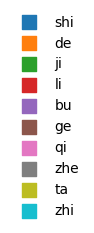

100%|██████████| 256/256 [00:53<00:00,  4.78it/s]

disc_elecs: {0, 1, 2, 128, 5, 135, 8, 9, 136, 137, 138, 13, 14, 15, 139, 140, 142, 143, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 32, 166, 167, 168, 169, 170, 171, 172, 173, 46, 174, 48, 49, 175, 180, 181, 182, 183, 184, 185, 186, 59, 187, 188, 189, 190, 64, 191, 197, 199, 201, 204, 214, 215, 95, 96, 226, 100, 231, 110, 111, 112, 242, 243, 254, 253, 126}


In [12]:
sylb_thres_length = 0.2
P01= 0.05
sylb_back = 0.4
sylb_forward = 0.8

sylb_ecog_mat,_,_,mat = read_ecog_mat(sylb_back,sylb_forward,sylb_mat,channelNum,key_elecs=[],
        key_label=[],oppolabel=False,key_sentence=[],opposentence=False, key_paragraph=[13,14,15,16],oppoparagraph=True,
        hz=hz, block=4) 
plot = False #True
save = False #[142,] must set plot as Ture first
sylb_elecs = pick_disc_electrodes2(List=sylbList,mat=mat, ecog_mat=sylb_ecog_mat,thres_length=sylb_thres_length,
                                  channelNum=channelNum,P0=P01)

In [13]:
print(sylb_elecs)
np.save(subject+'_anovasylb_elecs',sylb_elecs)
'''
0, 1, 2, 128, 5, 135, 8, 9, 136, 137,
138, 13, 14, 15, 139, 140, 142, 143, 150, 151,
152, 153, 154, 155, 156, 157, 158, 159, 32, 166,
167, 168, 169, 170, 171, 172, 173, 46, 174, 48,
49, 175, 180, 181, 182, 183, 184, 185, 186, 59,
187, 188, 189, 190, 191, 197, 199, 201, 204, 211,
214, 215, 95, 96, 226, 100, 231, 110, 111, 112,
242, 243, 254, 253, 126
'''

[  0   1   2   5   8   9  13  14  15  32  46  48  49  59  64  95  96 100
 110 111 112 126 128 135 136 137 138 139 140 142 143 150 151 152 153 154
 155 156 157 158 159 166 167 168 169 170 171 172 173 174 175 180 181 182
 183 184 185 186 187 188 189 190 191 197 199 201 204 214 215 226 231 242
 243 253 254]


'\n0, 1, 2, 128, 5, 135, 8, 9, 136, 137,\n138, 13, 14, 15, 139, 140, 142, 143, 150, 151,\n152, 153, 154, 155, 156, 157, 158, 159, 32, 166,\n167, 168, 169, 170, 171, 172, 173, 46, 174, 48,\n49, 175, 180, 181, 182, 183, 184, 185, 186, 59,\n187, 188, 189, 190, 191, 197, 199, 201, 204, 211,\n214, 215, 95, 96, 226, 100, 231, 110, 111, 112,\n242, 243, 254, 253, 126\n'

select paraqraph:[13, 14, 15, 16] oppo
read_ecog: (775, 256, 400)


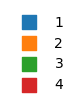

100%|██████████| 256/256 [00:24<00:00, 10.35it/s]

disc_elecs: {0, 1, 2, 5, 8, 9, 136, 137, 13, 14, 15, 151, 152, 156, 32, 166, 167, 168, 171, 172, 46, 174, 48, 181, 183, 59, 188, 189, 197, 198, 199, 75, 204, 78, 211, 214, 95, 96, 226, 100, 228, 230, 110, 111, 112, 242, 253, 254}


In [14]:
tone_thres_length = 0.1
P02= 0.05
tone_back = 0.5
tone_forward = 0.5
channelNum = 256

tone_ecog_mat,_,_,mat = read_ecog_mat(tone_back,tone_forward,sylb_mat,channelNum,key_elecs=[],
        key_label=[],oppolabel=False,key_sentence=[],opposentence=False, key_paragraph=[13,14,15,16],oppoparagraph=True,
        hz=hz, block=4) 
plot = False #True
save = False #[254,]
tone_elecs = pick_disc_electrodes3(List=toneList,mat=mat, ecog_mat=tone_ecog_mat,thres_length=tone_thres_length,
                                channelNum=channelNum,P0=P02,row=5)

In [15]:
print(tone_elecs)
np.save(subject+'_anovatone_elecs',tone_elecs)
'''
0, 1, 2, 5, 8, 9, 136, 137, 13, 14,
15, 151, 152, 156, 32, 166, 167, 168, 171, 172,
46, 174, 48, 181, 183, 59, 189, 197, 198, 199,
204, 78, 214, 95, 96, 226, 100, 228, 230, 110,
111, 112, 242, 253, 254
'''

[  0   1   2   5   8   9  13  14  15  32  46  48  59  75  78  95  96 100
 110 111 112 136 137 151 152 156 166 167 168 171 172 174 181 183 188 189
 197 198 199 204 211 214 226 228 230 242 253 254]


'\n0, 1, 2, 5, 8, 9, 136, 137, 13, 14,\n15, 151, 152, 156, 32, 166, 167, 168, 171, 172,\n46, 174, 48, 181, 183, 59, 189, 197, 198, 199,\n204, 78, 214, 95, 96, 226, 100, 228, 230, 110,\n111, 112, 242, 253, 254\n'

In [2]:
#load elecs back for 2D plot
'''
subject='PA4'
resp_elecs = np.load(subject+'_resp_elecs.npy')
sylb_elecs = np.load(subject+'_anovasylb_elecs.npy')
tone_elecs = np.load(subject+'_anovatone_elecs.npy')
'''

In [16]:
Brain2D_path = './2D_brain/'

import matplotlib.image as mpimg
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

img = mpimg.imread(Brain2D_path + subject + "_brain2D.png")
xy = sio.loadmat(Brain2D_path + subject + "_elec_pos2D.mat")['elecmatrix']

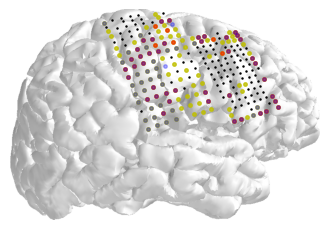

In [17]:
n_chans = 256
save = False
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(img)
bad_elecs = []
bad_elecs = [1,2,3,4,6,9,10,14,15,16,31,32,33,47,48,49,70,76,78,79,80,81,96,
             97,101,112,113,115,145,207,208,209,241,]################start from 0 be careful
resp_elecs_set = set(resp_elecs)
tone_elecs_set = set(tone_elecs)
sylb_elecs_set = set(sylb_elecs)
bad_elecs_set = set(bad_elecs)

# Filter out the numbers in resp_elecs, tone_elecs, sylb_elecs, and bad_elecs from range(256)
valid_indices = [i for i in range(n_chans) if i not in (resp_elecs_set | tone_elecs_set | sylb_elecs_set | bad_elecs_set)]

for i in valid_indices:
    ax.plot(xy[i][0], xy[i][1], 'k.', markersize=1.5) 
    #ax.text(xy[i][0], xy[i][1], str(i),fontsize=8)
for i in resp_elecs:
    ax.plot(xy[i][0], xy[i][1], 'yo', alpha=0.8, markersize=2.5) 
    #ax.text(xy[i][0], xy[i][1], str(i),fontsize=8)
for i in tone_elecs:
    ax.plot(xy[i][0], xy[i][1], 'ro', alpha = 0.5, markersize=2.5) 
    #ax.text(xy[i][0], xy[i][1], str(i),fontsize=8)
for i in sylb_elecs:
    ax.plot(xy[i][0], xy[i][1], 'bo', alpha = 0.3, markersize=2.5) 
    #ax.text(xy[i][0], xy[i][1], str(i),fontsize=8)
ax.axis("off")
if save:
    plt.savefig(subject+"_2D_elecs.svg", format="svg", dpi=300)

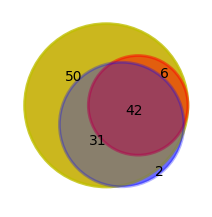

In [18]:
# Create subsets for the Venn diagram
only_resp = set(resp_elecs) - set(tone_elecs) - set(sylb_elecs)
only_tone = set(tone_elecs) - set(resp_elecs) - set(sylb_elecs)
only_sylb = set(sylb_elecs) - set(resp_elecs) - set(tone_elecs)
overlap_resp_tone = set(resp_elecs) & set(tone_elecs) - set(sylb_elecs)
overlap_resp_sylb = set(resp_elecs) & set(sylb_elecs) - set(tone_elecs)
overlap_tone_sylb = set(tone_elecs) & set(sylb_elecs) - set(resp_elecs)
overlap_all = set(resp_elecs) & set(tone_elecs) & set(sylb_elecs)

plt.figure(figsize=(2.5,2.5))
# Create a Venn diagram plot
venn_plot = venn3(subsets=(len(only_resp), len(only_tone), len(overlap_resp_tone),
                           len(only_sylb), len(overlap_resp_sylb), len(overlap_tone_sylb),
                           len(overlap_all)), set_labels=('   ', '  ', ' '))

# Customize plot elements (colors, alpha, etc.)
venn_plot_circles = venn3_circles(subsets=(len(only_resp), len(only_tone), len(overlap_resp_tone),
                                           len(only_sylb), len(overlap_resp_sylb), len(overlap_tone_sylb),
                                           len(overlap_all)))

# Set circle colors
venn_plot_circles[0].set_color('y')
venn_plot_circles[0].set_alpha(0.8)
venn_plot_circles[1].set_color('r')
venn_plot_circles[1].set_alpha(0.5)
venn_plot_circles[2].set_color('b')
venn_plot_circles[2].set_alpha(0.3)

for text in venn_plot.set_labels:
    text.set_fontsize(10)

# Save the plot as an SVG with transparent background
if save:
    plt.savefig(subject + '_venn_diagram.svg', transparent =True, dpi=300)
# Show the plot
plt.show()